## Capstone Week 5 EDA

In [1]:
from SlideRunner.dataAccess.database import Database
import SlideRunner.dataAccess.database
import os
import numpy as np
import pandas as pd
import openslide
import cv2

In [2]:

test_slides = ['14','18','3','22','10','15','21']


### Query all databases for the respective classes. Joint query for same order

In [3]:
DB = Database().open('../../databases/MITOS_WSI_CMC_ODAEL_TR.sqlite')
DB.execute('ATTACH `../../databases/MITOS_WSI_CMC_MEL.sqlite` as MEL;')
DB.execute('ATTACH `../../databases/MITOS_WSI_CMC_CODAEL_TR_ROI.sqlite` as CODAEL;')

ODAEL = DB.execute("""
SELECT * FROM (
SELECT filename, MitoticFigures, MitoticFigureLookalikes FROM 
(SELECT COUNT(*) as MitoticFigureLookalikes, slide from Annotations where agreedClass==1 group by slide) as cls1
LEFT JOIN (SELECT COUNT(*) as MitoticFigures, slide from Annotations where agreedClass==2 group by slide) as cls2 on cls2.slide == cls1.slide
LEFT JOIN Slides on Slides.uid == cls2.slide order by mitoticFigures) as ODAEL
LEFT JOIN 
(
SELECT filename, MitoticFigures, MitoticFigureLookalikes FROM (
SELECT COUNT(*) as MitoticFigures, slide from MEL.Annotations where agreedClass==2 group by slide) as cls2
LEFT JOIN (SELECT COUNT(*) as MitoticFigureLookalikes, slide from MEL.Annotations where agreedClass==1 group by slide) as cls1 on cls1.slide == cls2.slide
LEFT JOIN MEL.Slides on Slides.uid == cls2.slide order by mitoticFigures
) as MEL on MEL.filename == ODAEL.filename
LEFT JOIN 
(
SELECT filename, MitoticFigures, MitoticFigureLookalikes FROM 
(SELECT COUNT(*) as MitoticFigureLookalikes, slide from CODAEL.Annotations where agreedClass==1 group by slide) as cls1
LEFT JOIN (SELECT COUNT(*) as MitoticFigures, slide from CODAEL.Annotations where agreedClass==2 group by slide) as cls2 on cls2.slide == cls1.slide
LEFT JOIN MEL.Slides on Slides.uid == cls2.slide order by mitoticFigures
) as CODAEL on CODAEL.filename == ODAEL.filename order by CODAEL.mitoticFigures


""").fetchall()

Output everything in LateX table format

In [4]:
DB.execute("""SELECT COUNT(*) as MitoticFigureLookalikes, slide from Annotations where agreedClass==7 group by slide""").fetchall()

[]

In [5]:
ODAEL[0]

('4eee7b944ad5e46c60ce.svs',
 61,
 196,
 '4eee7b944ad5e46c60ce.svs',
 47,
 114,
 '4eee7b944ad5e46c60ce.svs',
 64,
 193)

### Iterate through images

In [34]:


dbTumor = Database()

dbTumor.open('../../databases/MITOS_WSI_CMC_CODAEL_TR_ROI.sqlite')
# pandas df for summary stats
columns = ['file name', 'area (mm2)','MEL mit','ODAEL mit','MFs','MEL non-mit','ODAEL non-mit','Total non-mit','set']
rows = np.arange(0,21)
df_EDA = pd.DataFrame(index = rows, columns=columns)

totalarea = 0
totalmit = 0
totalnonmit = 0
totalmit_mel, totalnonmit_mel = 0,0
totalmit_odael, totalnonmit_odael = 0,0
for idx, (filename, mitA, nonmitA, _, mit,nonmit, _,  mitC,nonmitC) in enumerate(ODAEL):

    dbTSlide = dbTumor.findSlideWithFilename(os.path.basename(filename), slidepath='')
    dbTumor.loadIntoMemory(dbTSlide)
    
    slide = openslide.open_slide('../../WSI/'+filename)


    positiveId = dbTumor.findClassidOfClass('Tumor region')[0][0]
    import matplotlib.path as p

    micronsPerPixel = slide.properties[openslide.PROPERTY_NAME_MPP_X]
    mpp_scaled = float(slide.level_downsamples[-1]) * float(micronsPerPixel)  

    slideActiveMap = np.zeros((slide.level_dimensions[-1][::-1]))
    ds = slide.level_downsamples[-1]
    for anno in dbTumor.annotations.keys():
        if (dbTumor.annotations[anno].agreedLabel()==positiveId) and (type(dbTumor.annotations[anno]) == type(dbTumor.annotations[anno]) == SlideRunner.dataAccess.annotations.polygonAnnotation):
            co = dbTumor.annotations[anno].coordinates
            p3 = np.int32([np.asarray(co)/ds])
            cv2.fillPoly(slideActiveMap, p3,color=[255] )

    for anno in dbTumor.annotations.keys():
        if not (dbTumor.annotations[anno].agreedLabel()==positiveId) and (type(dbTumor.annotations[anno]) == type(dbTumor.annotations[anno]) == SlideRunner.dataAccess.annotations.polygonAnnotation):
            co = dbTumor.annotations[anno].coordinates
            p3 = np.int32([np.asarray(co)/ds])
            cv2.fillPoly(slideActiveMap, p3,color=[0] )
    mm2 = np.sum(slideActiveMap>0)*mpp_scaled*mpp_scaled/1E6
    totalarea += mm2
    totalmit += mitC
    totalnonmit += nonmitC
    
    totalmit_mel, totalnonmit_mel = totalmit_mel+mit, totalnonmit_mel+nonmit
    totalmit_odael, totalnonmit_odael = totalmit_odael+mitA, totalnonmit_odael+nonmitA
    
    fname = filename.replace('_','\\_')
    # update pandas df
    variables = [fname, mm2, mit, mitA, mitC, nonmit, nonmitA, nonmitC, 'test' if str(dbTSlide) in test_slides else 'train']

    for i in range(0,len(columns)):
        df_EDA[columns[i]].iloc[idx] = variables[i]

    #print(f"{idx+1} & {fname} & {mm2:.2f}\,$\\mathrm"+"{mm2}"+f"^2$ & {mit:,d} / {mitA:,d} / {mitC:,d} & {nonmit:,d} / {nonmitA:,d} / {nonmitC:,d} & {'test' if str(dbTSlide) in test_slides else 'train'} \\\\ ")
    

### Add density and class imbalance statistics

In [85]:
# Copy df_EDA to new df
dfe = df_EDA.copy()

# change data types
dfe = dfe.infer_objects()
dfe = dfe.astype({'file name': 'string', 'set': 'string'})

In [91]:
# Insert density and ratio statistics
dfe.insert(5, 'MFs density (MFs/mm2)', dfe['MFs']/dfe['area (mm2)'])
dfe.insert(9, 'Non-mit density (Non-mit/mm2', dfe['Total non-mit']/dfe['area (mm2)'])
dfe['MFs to Non-mit ratio'] = dfe['MFs']/dfe['Total non-mit']


### Descriptive statistics

In [94]:
dfe.describe()

,area (mm2),MEL mit,ODAEL mit,MFs,MFs density (MFs/mm2),MEL non-mit,ODAEL non-mit,Total non-mit,Non-mit density (Non-mit/mm2,MFs to Non-mit ratio
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,207.622757,635.333333,673.857143,662.238095,4.020871,1263.142857,1720.714286,1732.333333,11.400572,0.332505
std,140.457526,562.881456,586.919951,579.758131,3.881186,920.345548,1130.567076,1138.716617,8.872536,0.131770
min,26.291739,47.000000,61.000000,64.000000,0.448170,114.000000,196.000000,193.000000,2.582311,0.125850
25%,66.059741,139.000000,155.000000,153.000000,1.292533,404.000000,680.000000,691.000000,5.619277,0.214156
50%,226.394953,578.000000,642.000000,612.000000,3.102427,1143.000000,1596.000000,1653.000000,7.867378,0.331606
75%,273.880910,1097.000000,1114.000000,1085.000000,4.965614,1832.000000,2550.000000,2552.000000,13.425868,0.421725
max,513.280961,1949.000000,2035.000000,1993.000000,15.169297,3598.000000,4408.000000,4450.000000,33.848871,0.555471


In [8]:
totalnonmit_mel, totalnonmit_odael, totalnonmit

(26526, 36135, 36379)

In [9]:
totalmit_mel, totalmit_odael, totalmit


(13342, 14151, 13907)

### Plots

In [104]:
import matplotlib.pyplot as plt

#### Class imbalance on WSIs

Text(0.5, 1.0, 'Class imbalance on 21 WSIs')

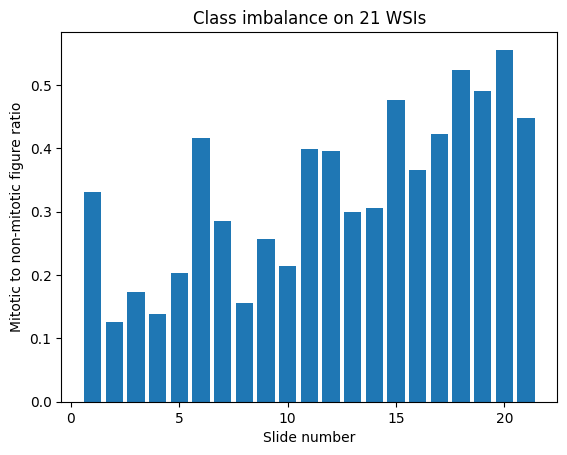

In [103]:
plt.figure()
plt.bar(dfe.index+1, dfe['MFs to Non-mit ratio'])
plt.xlabel('Slide number')
plt.ylabel('Mitotic to non-mitotic figure ratio')
plt.title('Class imbalance on 21 WSIs')


#### Mitotic and non-mitotic figure density on WSIs

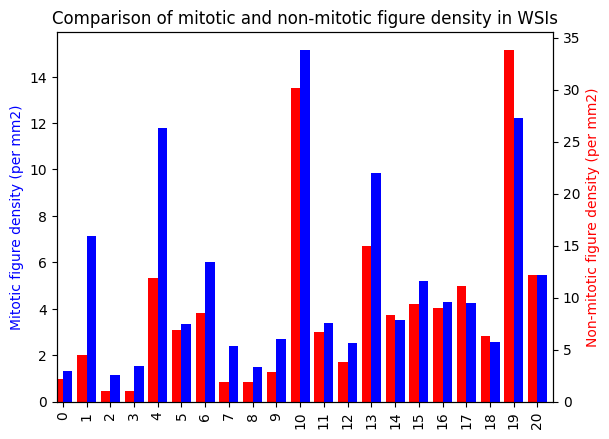

In [132]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

dfe['MFs density (MFs/mm2)'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
dfe['Non-mit density (Non-mit/mm2'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Mitotic figure density (per mm2)', color='blue')
ax.set_title('Comparison of mitotic and non-mitotic figure density in WSIs')
ax2.set_ylabel('Non-mitotic figure density (per mm2)', color='red')

plt.show()

### WSI total area

In [10]:
print('Total area: ',totalarea,'mm^2')
print('mitotic figures in CODAEL data set',totalmit)
print('nonmitotic figures in CODAEL data set',totalnonmit)


Total area:  4360.07788915561 mm^2
mitotic figures in CODAEL data set 13907
nonmitotic figures in CODAEL data set 36379


### Open questions and issues

* We have full slide .svs images. How do we split the images and attach annotations to them using the SQLite database?
* What do the columns mean inside of Annotation and Slide databases?
* How do we obtain and show separate images from slides with annotations in notebook environment?
* Major Issue: the code from the original authors uses fastAI v1 but newer Mac OS cannot run certain dependencies for fastAI v1 so replication of author's project is difficult or impossible
* How do we want to approach this project?
    * Should we start from scratch? Take raw .svs images and match annotations from SQLite databases before working with them?
    * Should we start go down the simpler route and build simple classification models so that we can extract image embeddings easily?
    * How do we translate cancer images to text without domain expertise? Should we write our own explanations as a POC and try out image-to-text models?
    * Annotated images have number of cancer cells and number of cancer regions which would be useful for final output report. Do we forego this if we want to keep it simple?